### Ant Colony Optimization (ACO) for symmetric Traveling Salesman Problem (TSP)
For graphs given by n euclidian points, where n is the number of nodes in our graph

### File Read

In [4]:
#readTSPFromFile
import numpy as np
def readTSPFromFile(filePath):
    f = open(filePath, 'r')

    name = f.readline().strip().split()[1]             # name
    comment = f.readline().strip().split()[1]          # comment
    type = f.readline().strip().split()[1]             # type
    dimension = int(f.readline().strip().split()[1])   # dimension
    edge_weight_type = f.readline().strip().split()[1] # edge_weight_type
    node_coord_section = []
    f.readline() # past node_coord_section

    for i in range(dimension):
        line = f.readline().strip().split(' ')
        node = int(line[0])
        x = float(line[1])
        y = float(line[2])
        node_coord_section.append((x, y))

    return {
        'name' : name,
        'comment' : comment,
        'type' : type,
        'dimension' : dimension,
        'edge_weight_type' : edge_weight_type,
        'nodes' : node_coord_section
    }

### ACO Algorithm

#### Definitions
Probability of ants choosing a path: $P_{ij}(t) = \frac{\tau_{ij}^\alpha + \eta_{ij}^\beta}{\sum(\tau^\alpha + \eta^\beta)}$ <br/>
Where $\tau$ is the amount of pheromones and $\eta$ is the inverse of the distance <br/>
$\alpha$ and $\beta$ are algorithm parameters for which factor to give more importance to <br/>
<br/>
Pheromones deposit after successfully finding the path: $\tau^{(i+1)} = \tau^i + \Delta\tau$<br/>
Where $\Delta\tau$ is a parameter and $i$ is the iteration number <br/>

Pheromones evaporation: $\tau^{(i+1)} = (1 - \rho)\tau^i$<br/>
Where $\rho$ is a parameter evaporation rate<br/>

Restrictions<br/>
$0 \le \alpha, \beta, \rho \le 1 $

In [5]:
#ACO_TSP_run
import numpy as np
import ipywidgets as widgets

def invertDistances(
        space : np.ndarray      #TPS space
):
    distances = np.zeros((space.shape[0], space.shape[0]))
    # distance matrix n x n
    for index, point in enumerate(space):
        distances[index] = np.sqrt(((space - point) ** 2).sum(axis=1))
    #ignore division by zero warning
    with np.errstate(all = 'ignore'):
        inv_distances = 1  / distances

    #replacing division by zero error
    inv_distances[inv_distances == np.inf] = 0
    return inv_distances

def initAnts(
        space : np.ndarray,     # TSP space
        colony : int            # size of our ants colony
):
    return np.random.randint(space.shape[0], size=colony)

def startAnts(
        space : np.ndarray,         # TPS space (n x n)
        positions : np.ndarray,     # Ants' starting positions (n x 1)
        inv_distances : np.ndarray, # Inverted distances from all nodes to all nodes (n x n)
        pheromones : np.ndarray,    # Pheromones left on the edges by ants (n x n)
        alpha : float,              # Parameter for algorithm, importance of pheromones of an edge 
        beta : float,               # Parameter for algorithm, importance of distance of an edge
        del_tau : float             # Parameter for algorithm, pheromones releasing rate
):
    # *multidimensional array for our paths
    paths = np.zeros((space.shape[0], positions.shape[0]), dtype=int) - 1
    # *for every ant, node zero is their position from positions
    paths[0] = positions

    # *building the rest of the path
   # print('starting iterating nodes')
    for node in range(1, space.shape[0]):
        #print(f'at node {node}')
        # *for every ant
        for ant in range(positions.shape[0]):
            #print(f'at ant {ant}')
            # *calculating the probabilities to travel to next nodes
            next_node_probabilities = (pheromones[positions[ant]] ** alpha + inv_distances[positions[ant]] ** beta) / (
                                     pheromones[positions[ant]].sum() ** alpha + inv_distances[positions[ant]].sum() ** beta)
            # *obtaining the index of the next node by taking the one with maximum probability
            next_node_index = np.argwhere(next_node_probabilities == np.amax(next_node_probabilities))[0][0]

        
            # *now iterate descending from the max probability index until we find one we haven't visited yet
            while next_node_index in paths[:, ant]:
                # *don't want to obtain this index again => make its probability 0
                next_node_probabilities[next_node_index] = 0.0
                # *retry 
                next_node_index = np.argwhere(next_node_probabilities == np.amax(next_node_probabilities))[0][0]
            # *found our next node with max probability available
            paths[node, ant] = next_node_index

            # *updating our pheromones
            pheromones[node, next_node_index] = pheromones[node, next_node_index] + del_tau
    # *swap the lines and columns of our paths matrix
    # *for better access
    paths = np.swapaxes(paths, 0, 1)
    return paths

def ACO_TSP_run(
        space : np.ndarray,     # TSP space
        iterations : int = 20,  # Ending condition - number of iterations
        colony : int = 50,      # Number of ants in the colony
        alpha : float = 1.0,    # Parameter for algorithm, importance of pheromones of an edge
        beta : float = 1.0,     # Parameter for algorithm, importance of distance of an edge
        del_tau : float = 1.0,  # Parameter for algorithm, pheromones releasing rate
        rho: float = 0.5,       # Parameter for algorithm, pheromones evaporation rate
):
    # * inverting distances for the formula later
    inv_distances = invertDistances(space)
    # * from the formula
    inv_distances = inv_distances ** beta

    # *initializing pheromones
    pheromones = np.zeros((space.shape[0], space.shape[0]))

    # *minimum variables
    min_distance = None
    min_path = None

    progressBar = widgets.IntProgress(min=0, max=iterations)
    display(progressBar)

    # !starting iterations
    for i in range(iterations):
        # *initializing ants' random positions before starting their search 
        positions = initAnts(space, colony)
        # !initiating the ants' walk for current iteration
        paths = startAnts(space, positions, inv_distances, pheromones, alpha, beta, del_tau)
        # !evaporation of pheromones
        pheromones *= (1 - rho)
        # !iterating paths to look for the minimum path
        for path in paths:
            distance = 0
            for node in range(1, path.shape[0]):
                i = int(path[node - 1])
                j = int(path[node])
                distance += np.sqrt(((space[j] - space[i]) ** 2).sum())
            if not min_distance or distance < min_distance:
                min_distance = distance
                min_path = path
        progressBar.value += 1
    # !appending the first node to obtain our Hamiltonian cycle
    min_path = np.append(min_path, min_path[0])
    return (min_distance, min_path)

### Space plot

IntProgress(value=0, max=20)

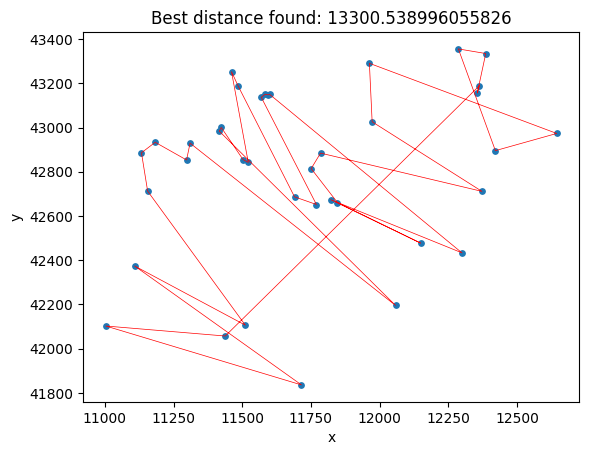

IntProgress(value=0, max=20)

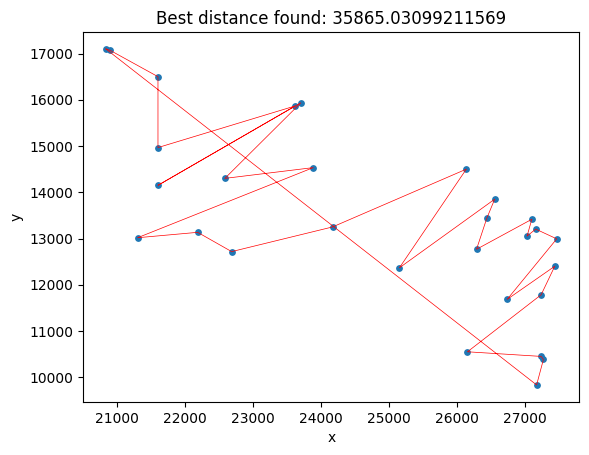

IntProgress(value=0, max=20)

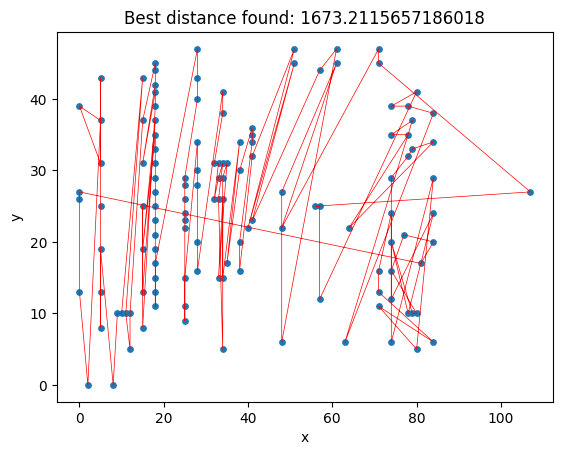

IntProgress(value=0, max=20)

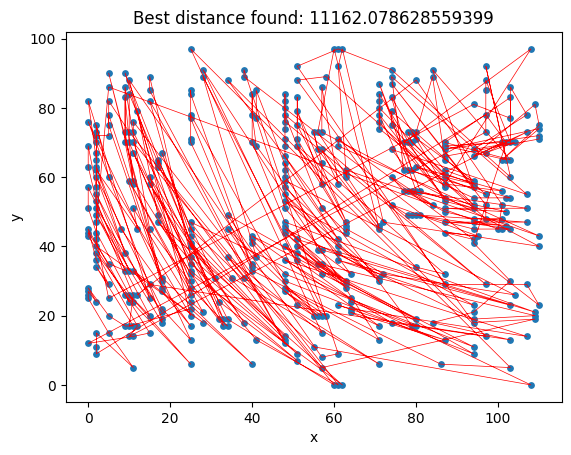

In [6]:
#plotSpace
import matplotlib.pyplot as plt
def plotSpace(network):
    space = np.array(network['nodes'])

    min_distance, min_path = ACO_TSP_run(space)
    plt.scatter(space[:, 0], space[:, 1], s = 15)
    plt.plot(space[min_path, 0], space[min_path, 1], color='red', linewidth=0.5)
    plt.title(f'Best distance found: {min_distance}')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.show()
    plt.close()


network = readTSPFromFile('tsp_dataset\\dj38.tsp')
plotSpace(network)
network = readTSPFromFile('tsp_dataset\\wi29.tsp')
plotSpace(network)
network = readTSPFromFile('tsp_dataset\\xqf131.tsp')
plotSpace(network)
network = readTSPFromFile('tsp_dataset\\pbn423.tsp')
plotSpace(network)
# !too big
# network = readTSPFromFile('tsp_dataset\\lu980.tsp')
# plotSpace(network)
